<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/TransferLearning_in_NNN_plus2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTP

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


In [2]:
nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Model

#### Accuracy, train and test functions

In [3]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [80]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  model.train()
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      # if(epoch==0 and i==0):
      #   print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [5]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      # if i % 20 == 0:
      print(i,':: Loss:', error.item(),',Test accuracy:', acc_train)

In [6]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Initialize lists to store predictions for each class
    predictions_class_1 = []
    predictions_class_2 = []

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()  # Move inputs to the device (e.g., GPU)
            outputs = model(inputs)  # Forward pass to get predictions

            # Assuming the output is softmax probabilities
            # Separate the probabilities for class-1 and class-2
            class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
            class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

            predictions_class_1.extend(class_1_probs)
            predictions_class_2.extend(class_2_probs)

    # `predictions_class_1` contains the probabilities for class-1 for all test samples
    # `predictions_class_2` contains the probabilities for class-2 for all test samples
    # You can further process or save these predictions as needed
    return predictions_class_1, predictions_class_2


In [7]:
def get_predictions_np(input_matrix, model, device):
    # Convert numpy matrix to PyTorch tensor
    inputs = torch.tensor(input_matrix).to(device).float()

    # Forward pass to get predictions
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = model(inputs)  # Forward pass to get predictions

        # Assuming the output is softmax probabilities
        # Separate the probabilities for class-1 and class-2
        class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
        class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

    # `class_1_probs` contains the probabilities for class-1 for all samples
    # `class_2_probs` contains the probabilities for class-2 for all samples
    # You can further process or save these predictions as needed
    return class_1_probs, class_2_probs


#### File loaders

In [130]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms

# Define a function to generate rotated data
def rotate_data(X):
    rotated_X = torch.rot90(X, k=1, dims=(0, 1))  # Rotate data by 90 degrees clockwise
    return rotated_X

# Modify the dataset to include both original and rotated data
def create_combined_dataset_with_augmentation(original_dataset):
    combined_dataset = []
    for X, Y in original_dataset:
        rotated_X = rotate_data(X)
        combined_dataset.append((X, Y))  # Add original data
        combined_dataset.append((rotated_X, Y))  # Add rotated data
    return combined_dataset

In [128]:
def create_combined_dataset(dataset1, dataset2):
    combined_dataset = []
    for X, Y in dataset1:
        combined_dataset.append((X, Y))  # Add original data
    for X, Y in dataset2:
        combined_dataset.append((X, Y))  # Add original data
    return combined_dataset

In [8]:
def file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [9]:
def full_file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    Y = data['y']
    # Tc = 2.27 # For a square lattice following Ising Model
    y = Y > Tc
    y = to_categorical(y.astype(int))
    return X, y, Y

#### Dataset and DataLoader

In [10]:
class IsingDataset(Dataset):
    def __init__(self, x, y, anti_ferro=False):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))
        self.anti_ferro = anti_ferro

    def __getitem__(self, index):
        if self.anti_ferro:
            x_transformed = self._apply_anti_ferro(self.x[index])
            return x_transformed, self.y[index]
        else:
            return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

    def _apply_anti_ferro(self, x):
        # Apply anti-ferromagnetic transformation
        return (-1) ** torch.arange(x.size(0)).unsqueeze(1) + (-1) ** torch.arange(x.size(1))

# # Example usage
# x = ...  # Your input data
# y = ...  # Your target labels
# anti_ferro = True  # Set to True to apply the anti-ferromagnetic transformation
# dataset = IsingDataset(x, y, anti_ferro=anti_ferro)


In [11]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a DataLoader named original_dataloader
# Define a new DataLoader class to subset the original DataLoader
class SubsetDataLoader(DataLoader):
    def __init__(self, dataloader, num_batches):
        super(SubsetDataLoader, self).__init__(dataloader.dataset, batch_size=dataloader.batch_size)
        self.dataloader = dataloader
        self.num_batches = num_batches
        self.current_batch = 0

    def __iter__(self):
        self.current_batch = 0
        self.dataloader_iter = iter(self.dataloader)
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        self.current_batch += 1
        return next(self.dataloader_iter)

Train and test data:

In [12]:
# Anti-ferromagnetic dataset: train and test

X_train_anti, X_test_anti, y_train_anti, y_test_anti, Y_train_anti, Y_test_anti = file_loader('data_anti.npz')

In [13]:
training_dataset_anti = IsingDataset(X_train_anti, y_train_anti)
testing_dataset_anti = IsingDataset(X_test_anti, y_test_anti)
batch_size = 128
train_dataloader_anti = DataLoader(dataset = training_dataset_anti, batch_size = batch_size, shuffle = False)
test_dataloader_anti = DataLoader(dataset = testing_dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Class: [0. 1.]
Temperature: 2.3


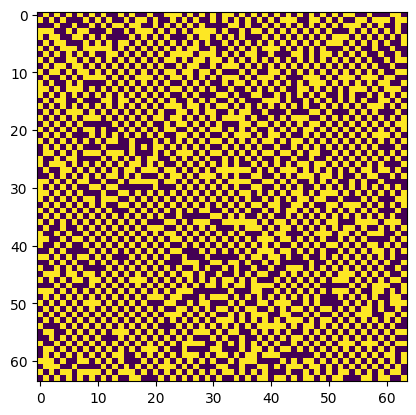

In [14]:
plt.imshow(X_train_anti[30])
print("Class:", y_train_anti[30])
print("Temperature:", Y_train_anti[30])

#### Fully Connected Neural Network

In [ ]:
class neural_network(nn.Module):
  def __init__(self):
    super(neural_network, self).__init__()
    self.main = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1),
        nn.Linear(Nx*Ny, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid()
    )
  def forward(self, input):
      return self.main(input)

In [ ]:
FCNN = neural_network().to(device)
criterion_FCNN = nn.BCELoss()
optimizer_FCNN = optim.Adam(FCNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# # Dataset 1, NN -> antiFe, NNN -> Fe
# X_anti, y_anti, Y_anti = full_file_loader('data_anti.npz')
# dataset_anti = IsingDataset(X_anti, y_anti)
# batch_size = 128
# dataloader_anti = DataLoader(dataset = dataset_anti, batch_size = batch_size, shuffle = False)

In [ ]:
train(FCNN, 10, criterion_FCNN, optimizer_FCNN, train_dataloader_anti)

Loss: 0.694808840751648 ,Train accuracy: 0.6015625
Loss: 0.6998928785324097 ,Train accuracy: 0.4765625
Loss: 0.6956212520599365 ,Train accuracy: 0.703125
Loss: 0.6933309435844421 ,Train accuracy: 0.5390625
Loss: 0.6729944348335266 ,Train accuracy: 0.546875
Loss: 0.6664677858352661 ,Train accuracy: 0.79296875
Loss: 0.7108287215232849 ,Train accuracy: 0.49609375
Loss: 0.6884220838546753 ,Train accuracy: 0.75
Loss: 0.6801477670669556 ,Train accuracy: 0.57421875
Loss: 0.6276676654815674 ,Train accuracy: 0.8671875
Loss: 0.6431004405021667 ,Train accuracy: 0.7734375
Loss: 0.6468219757080078 ,Train accuracy: 0.75390625
Loss: 0.6360934972763062 ,Train accuracy: 0.7890625
Loss: 0.601184606552124 ,Train accuracy: 0.8125
Loss: 0.566032886505127 ,Train accuracy: 0.8671875
Loss: 0.6966426372528076 ,Train accuracy: 0.79296875
Loss: 0.6068639159202576 ,Train accuracy: 0.80859375
Loss: 0.5976171493530273 ,Train accuracy: 0.8203125
Loss: 0.570264995098114 ,Train accuracy: 0.83203125
Loss: 0.52796196937

In [ ]:
test(FCNN, criterion_FCNN, test_dataloader_anti)

0 :: Loss: 0.1944330930709839 ,Test accuracy: 0.9296875
1 :: Loss: 0.3490474820137024 ,Test accuracy: 0.87890625
2 :: Loss: 0.2394697368144989 ,Test accuracy: 0.93359375
3 :: Loss: 0.3447885811328888 ,Test accuracy: 0.90625
4 :: Loss: 0.3742731213569641 ,Test accuracy: 0.890625
5 :: Loss: 0.1726294755935669 ,Test accuracy: 0.9375
6 :: Loss: 0.37815940380096436 ,Test accuracy: 0.89453125
7 :: Loss: 0.35600364208221436 ,Test accuracy: 0.890625
8 :: Loss: 0.22086834907531738 ,Test accuracy: 0.90625
9 :: Loss: 0.38123810291290283 ,Test accuracy: 0.875
10 :: Loss: 0.22011587023735046 ,Test accuracy: 0.9375
11 :: Loss: 0.39048415422439575 ,Test accuracy: 0.8671875
12 :: Loss: 0.5222269296646118 ,Test accuracy: 0.8671875
13 :: Loss: 0.22922751307487488 ,Test accuracy: 0.91015625
14 :: Loss: 0.31962859630584717 ,Test accuracy: 0.875
15 :: Loss: 0.3035730719566345 ,Test accuracy: 0.9296875
16 :: Loss: 0.4342727065086365 ,Test accuracy: 0.86328125
17 :: Loss: 0.3147673010826111 ,Test accuracy: 0

#### CNN:

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

## Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

## Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [16]:
CNN = ConvNet(Nx, Ny).to(device)
criterion_CNN = nn.BCELoss()
optimizer_CNN = optim.Adam(CNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [17]:
train(CNN, 10, criterion_CNN, optimizer_CNN, train_dataloader_anti)

Loss: 0.6911834478378296 ,Train accuracy: 0.6015625
Loss: 0.0819387286901474 ,Train accuracy: 0.9765625
Loss: 0.010372400283813477 ,Train accuracy: 1.0
Loss: 0.06475871801376343 ,Train accuracy: 0.9765625
Loss: 0.07788801193237305 ,Train accuracy: 0.9765625
Loss: 0.04800435155630112 ,Train accuracy: 0.984375
Loss: 0.026330027729272842 ,Train accuracy: 0.9921875
Loss: 0.04162187501788139 ,Train accuracy: 0.9921875
Loss: 0.014439670369029045 ,Train accuracy: 0.9921875
Loss: 0.013878967612981796 ,Train accuracy: 1.0
Loss: 0.010243971832096577 ,Train accuracy: 1.0
Loss: 0.02073645032942295 ,Train accuracy: 0.9921875
Loss: 0.037468113005161285 ,Train accuracy: 0.9921875
Loss: 0.029499903321266174 ,Train accuracy: 0.9921875
Loss: 0.022158564999699593 ,Train accuracy: 0.9921875
Loss: 0.013990726321935654 ,Train accuracy: 0.9921875
Loss: 0.02375848963856697 ,Train accuracy: 0.9921875
Loss: 0.010721063241362572 ,Train accuracy: 1.0
Loss: 0.01428645197302103 ,Train accuracy: 1.0
Loss: 0.00683799

In [18]:
test(CNN, criterion_CNN, test_dataloader_anti)

0 :: Loss: 0.07541362196207047 ,Test accuracy: 0.9921875
1 :: Loss: 0.05703245848417282 ,Test accuracy: 0.984375
2 :: Loss: 0.018215160816907883 ,Test accuracy: 0.9921875
3 :: Loss: 0.018244687467813492 ,Test accuracy: 0.9921875
4 :: Loss: 0.006369207054376602 ,Test accuracy: 1.0
5 :: Loss: 0.012952939607203007 ,Test accuracy: 0.9921875
6 :: Loss: 0.04294814541935921 ,Test accuracy: 0.9921875
7 :: Loss: 0.025407904759049416 ,Test accuracy: 0.984375
8 :: Loss: 0.028592273592948914 ,Test accuracy: 0.9921875
9 :: Loss: 0.014981485903263092 ,Test accuracy: 0.9921875
10 :: Loss: 0.01785825937986374 ,Test accuracy: 0.9921875
11 :: Loss: 0.0019818651489913464 ,Test accuracy: 1.0
12 :: Loss: 0.043637197464704514 ,Test accuracy: 0.984375
13 :: Loss: 0.05807701498270035 ,Test accuracy: 0.9765625
14 :: Loss: 0.0006219490896910429 ,Test accuracy: 1.0
15 :: Loss: 0.0022828758228570223 ,Test accuracy: 1.0
16 :: Loss: 0.00099460082128644 ,Test accuracy: 1.0
17 :: Loss: 0.10039760172367096 ,Test accur

In [19]:
torch.save(CNN.state_dict(), 'CNN_anti.pth')

### Feature Maps

In [20]:
# Example Usage:
# model = ConvNet(40, 40)
def plot_feature_map(model, x, y, print_data = False):
  x = torch.from_numpy(x).unsqueeze(0).float().to(device)
  feature_maps = model(x, return_feature_maps=True)

  # Plotting the first feature map from the first sample in the batch
  data = feature_maps[0, 0].cpu().detach().numpy()
  print(data)
  plt.imshow(data)
  plt.colorbar()
  plt.title(f'Temperature={y}')
  plt.show()

Text(0.5, 1.0, 'Temperature=1.4')

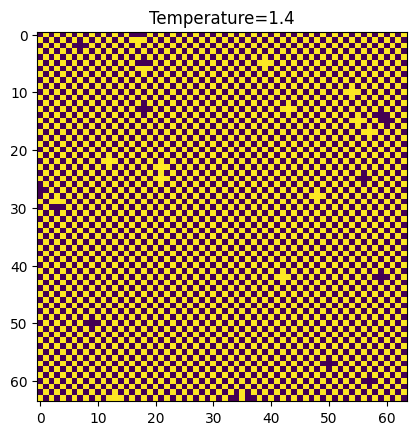

In [21]:
plt.imshow(X_train_anti[0])
plt.title(f"Temperature={Y_train_anti[0]}")

[[0.         0.01853183 0.         ... 0.         0.         0.83314335]
 [0.1021854  0.         0.1021854  ... 0.01853183 0.         0.        ]
 [0.         0.1021854  0.         ... 0.         0.         0.1021854 ]
 ...
 [0.02982375 0.01853183 0.         ... 0.         0.         0.1021854 ]
 [0.83314335 0.         0.1021854  ... 0.         0.1021854  0.        ]
 [0.         0.1021854  0.         ... 0.1021854  0.         0.02982375]]


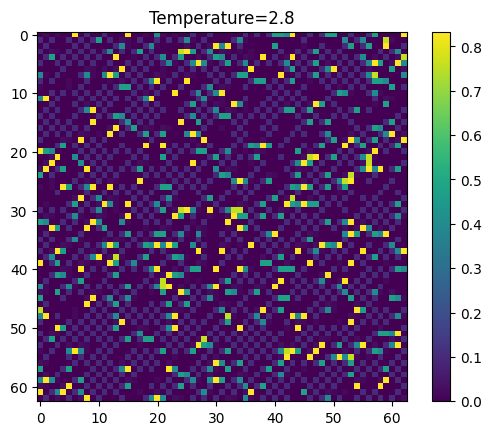

In [22]:
plot_feature_map(CNN, X_train_anti[2000], Y_train_anti[2000])

### Test on the R = +2 data

###### Loading the datasets and the trained model

In [28]:
X2, y2, Y2 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2.npz', 4.5)

In [32]:
dataset2 = IsingDataset(X2, y2)
batch_size = 128
dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


###### CNN

In [33]:
dataset2.__len__()

1800

In [34]:
test(CNN, criterion_CNN, dataloader2)

0 :: Loss: 77.94239807128906 ,Test accuracy: 0.0
1 :: Loss: 79.69538116455078 ,Test accuracy: 0.0
2 :: Loss: 77.57235717773438 ,Test accuracy: 0.0
3 :: Loss: 78.89511108398438 ,Test accuracy: 0.0
4 :: Loss: 76.48472595214844 ,Test accuracy: 0.0
5 :: Loss: 77.3636474609375 ,Test accuracy: 0.0
6 :: Loss: 17.88688850402832 ,Test accuracy: 0.75
7 :: Loss: 0.005372568964958191 ,Test accuracy: 1.0
8 :: Loss: 8.313768921652809e-05 ,Test accuracy: 1.0
9 :: Loss: 7.955499086165219e-07 ,Test accuracy: 1.0
10 :: Loss: 8.402476669289172e-05 ,Test accuracy: 1.0
11 :: Loss: 2.4169688472852613e-10 ,Test accuracy: 1.0
12 :: Loss: 1.7724785720929503e-05 ,Test accuracy: 1.0
13 :: Loss: 1.3301384438335617e-09 ,Test accuracy: 1.0
14 :: Loss: 2.6136188324699106e-08 ,Test accuracy: 1.0


In [35]:
pred_class1, pred_class2 = get_predictions(dataloader2, CNN)

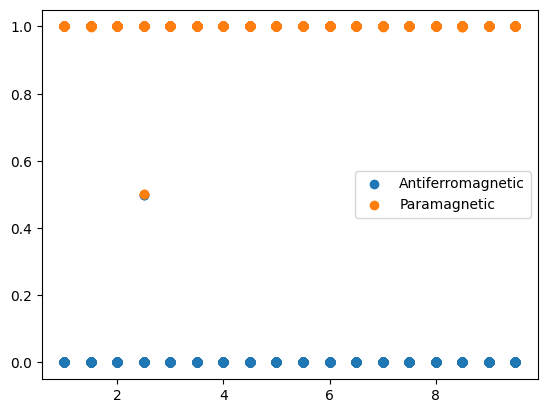

In [36]:
plt.scatter(Y2, pred_class1, label='Antiferromagnetic')
plt.scatter(Y2, pred_class2, label='Paramagnetic')
plt.legend()

###### Visualization

Text(0.5, 1.0, 'Temperature=9.0')

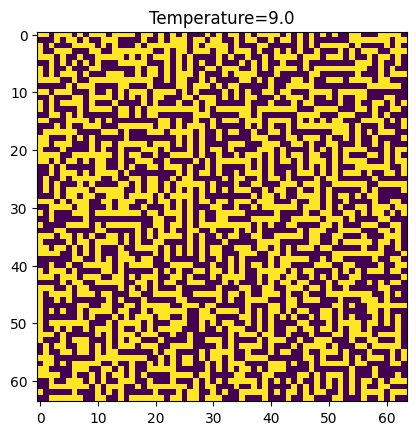

In [37]:
plt.imshow(X2[1600])
plt.title(f"Temperature={Y2[1600]}")

[[0.47338605 0.         0.         ... 0.83314335 0.40102434 0.        ]
 [0.         0.         0.1021854  ... 0.01853183 0.         0.83314335]
 [0.01853183 0.         0.         ... 0.         0.02982375 0.        ]
 ...
 [0.         0.         0.         ... 0.1021854  0.47338605 0.47338605]
 [0.         0.         0.47338605 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.83314335 0.47338605]]


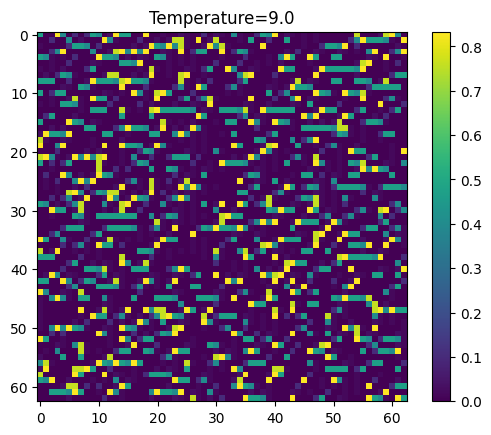

In [38]:
plot_feature_map(CNN, X2[1600], Y2[1600])

Text(0.5, 1.0, 'Temperature=1.0')

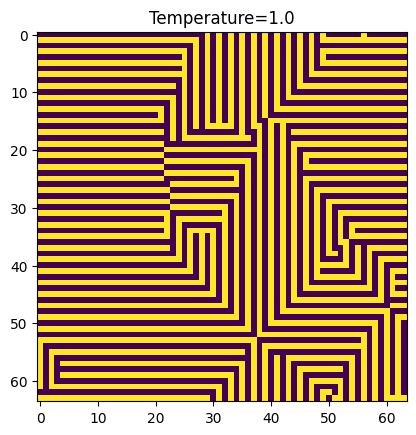

In [39]:
plt.imshow(X2[0])
plt.title(f"Temperature={Y2[0]}")

In [40]:
  x = X2[8]
  x = torch.from_numpy(x).unsqueeze(0).float().to(device)
  feature_maps = CNN(x, return_feature_maps=True)

  # Plotting the first feature map from the first sample in the batch
  data = feature_maps[0, 0].cpu().detach().numpy()
  data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.47338605, 0.47338605, 0.47338605, ..., 0.47338605, 0.47338605,
        0.47338605],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.47338605, 0.47338605, 0.47338605, ..., 0.47338605, 0.47338605,
        0.47338605],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.47338605 0.47338605 0.47338605 ... 0.47338605 0.47338605 0.47338605]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01853183 0.         0.         ... 0.01853183 0.         0.01853183]
 [0.         0.         0.47338605 ... 0.01853183 0.         0.01853183]
 [0.         0.         0.         ... 0.         0.02982375 0.        ]]


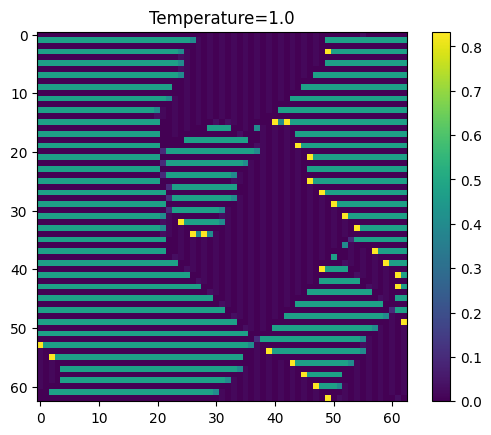

In [41]:
plot_feature_map(CNN, X2[0], Y2[0], print_data = True)

### Testing on the second (best) R=+2 data

###### Loading the datasets and the trained model

In [42]:
X1, y1, Y1 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best.npz', 4.5)

In [43]:
dataset1 = IsingDataset(X1, y1)
batch_size = 128
dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


###### CNN

In [45]:
dataset1.__len__()

1200

In [46]:
test(CNN, criterion_CNN, dataloader1)

0 :: Loss: 78.46733093261719 ,Test accuracy: 0.0
1 :: Loss: 76.0719985961914 ,Test accuracy: 0.0
2 :: Loss: 77.00880432128906 ,Test accuracy: 0.0
3 :: Loss: 70.47657775878906 ,Test accuracy: 0.09375
4 :: Loss: 3.869296882896833e-09 ,Test accuracy: 1.0
5 :: Loss: 1.4303594420006505e-10 ,Test accuracy: 1.0
6 :: Loss: 6.393663352355361e-05 ,Test accuracy: 1.0
7 :: Loss: 0.005375302862375975 ,Test accuracy: 1.0
8 :: Loss: 1.6784797551849806e-08 ,Test accuracy: 1.0
9 :: Loss: 5.1166371139999e-10 ,Test accuracy: 1.0


In [47]:
pred_class1, pred_class2 = get_predictions(dataloader1, CNN)

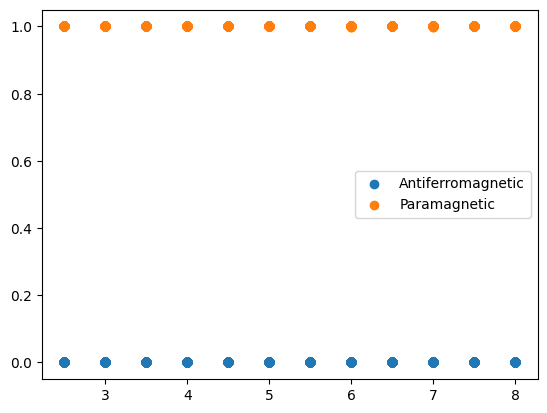

In [48]:
plt.scatter(Y1, pred_class1, label='Antiferromagnetic')
plt.scatter(Y1, pred_class2, label='Paramagnetic')
plt.legend()

Text(0.5, 1.0, 'Temperature=2.5')

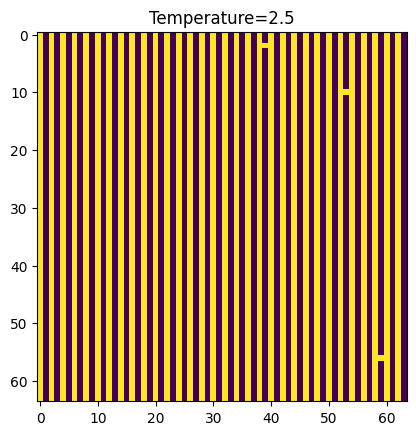

In [49]:
plt.imshow(X1[10])
plt.title(f"Temperature={Y1[10]}")

[[0.01853183 0.         0.01853183 ... 0.01853183 0.         0.01853183]
 [0.01853183 0.         0.01853183 ... 0.01853183 0.         0.01853183]
 [0.01853183 0.         0.01853183 ... 0.01853183 0.         0.01853183]
 ...
 [0.01853183 0.         0.01853183 ... 0.01853183 0.         0.01853183]
 [0.01853183 0.         0.01853183 ... 0.01853183 0.         0.        ]
 [0.01853183 0.         0.01853183 ... 0.01853183 0.         0.        ]]


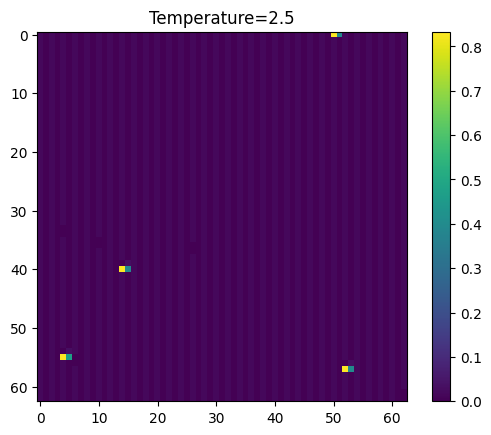

In [66]:
plot_feature_map(CNN, X1[0], Y1[0])

### Transfer Learning

###### Loading the Dataset

Full Data

In [258]:
X1, y1, Y1 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best.npz', 4.5)

In [259]:
dataset1 = IsingDataset(X1, y1)
batch_size = 128
dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [260]:
X2, y2, Y2 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best2.npz', 4.5)

In [261]:
dataset2 = IsingDataset(X2, y2)
batch_size = 128
dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [262]:
X3, y3, Y3 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best3.npz', 4.5)

In [263]:
dataset3 = IsingDataset(X3, y3)
batch_size = 128
dataloader3 = DataLoader(dataset = dataset3, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [264]:
X4, y4, Y4 = full_file_loader('data_64NNN_anti_noshuffle_Rplus2_best4.npz', 4.5)

In [265]:
dataset4 = IsingDataset(X4, y4)
batch_size = 128
dataloader4 = DataLoader(dataset = dataset4, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Train and test data

In [147]:
X_train1, X_test1, y_train1, y_test1, Y_train1, Y_test1 = file_loader('data_64NNN_anti_noshuffle_Rplus2_best.npz', 4.5)

In [148]:
training_dataset1 = IsingDataset(X_train1, y_train1)
testing_dataset1 = IsingDataset(X_test1, y_test1)
batch_size = 128
train_dataloader1 = DataLoader(dataset = training_dataset1, batch_size = batch_size, shuffle = False)
test_dataloader1 = DataLoader(dataset = testing_dataset1, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [149]:
X_train2, X_test2, y_train2, y_test2, Y_train2, Y_test2 = file_loader('data_64NNN_anti_noshuffle_Rplus2_best2.npz', 4.5)

In [150]:
training_dataset2 = IsingDataset(X_train2, y_train2)
testing_dataset2 = IsingDataset(X_test2, y_test2)
batch_size = 128
train_dataloader2 = DataLoader(dataset = training_dataset2, batch_size = batch_size, shuffle = False)
test_dataloader2 = DataLoader(dataset = testing_dataset2, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Combined Data

In [266]:
# Create the combined dataset
combined_dataset_wo_aug12 = create_combined_dataset(dataset2, dataset1)

# Create a new DataLoader for the combined dataset
combined_dataloader_wo_aug12 = DataLoader(dataset = combined_dataset_wo_aug12, batch_size=batch_size, shuffle=False)

In [267]:
# Create the combined dataset
combined_dataset_wo_aug123 = create_combined_dataset(combined_dataset_wo_aug12, dataset3)

# Create a new DataLoader for the combined dataset
combined_dataloader_wo_aug123 = DataLoader(dataset = combined_dataset_wo_aug123, batch_size=batch_size, shuffle=False)

In [255]:
# Create the combined dataset
combined_dataset_wo_aug1234 = create_combined_dataset(combined_dataset_wo_aug123, dataset4)

# Create a new DataLoader for the combined dataset
combined_dataloader_wo_aug1234 = DataLoader(dataset = combined_dataset_wo_aug1234, batch_size=batch_size, shuffle=False)

Augmented data

In [178]:
# Assuming you already have an original DataLoader named original_dataloader
# You can get the original dataset from original_dataloader.dataset
original_dataset1 = dataloader1.dataset

# Create the combined dataset
combined_dataset1 = create_combined_dataset_with_augmentation(original_dataset1)


# Create a new DataLoader for the combined dataset
combined_dataloader1 = DataLoader(dataset = combined_dataset1, batch_size=dataloader1.batch_size, shuffle=False)

# Now, new_dataloader contains both the original data and the 90-degree rotated data, with labels unchanged


In [179]:
# Assuming you already have an original DataLoader named original_dataloader
# You can get the original dataset from original_dataloader.dataset
original_dataset2 = dataloader2.dataset

# Create the combined dataset
combined_dataset2 = create_combined_dataset_with_augmentation(original_dataset2)


# Create a new DataLoader for the combined dataset
combined_dataloader2 = DataLoader(dataset = combined_dataset2, batch_size=dataloader2.batch_size, shuffle=False)

# Now, new_dataloader contains both the original data and the 90-degree rotated data, with labels unchanged


In [180]:
# Assuming you already have an original DataLoader named original_dataloader
# You can get the original dataset from original_dataloader.dataset
comb_dataset1 = combined_dataloader1.dataset
comb_dataset2 = combined_dataloader2.dataset

# Create the combined dataset
combined_dataset = create_combined_dataset(comb_dataset2, comb_dataset1)

# Create a new DataLoader for the combined dataset
combined_dataloader = DataLoader(dataset = combined_dataset, batch_size=combined_dataloader2.batch_size, shuffle=False)

# Now, new_dataloader contains both the original data and the 90-degree rotated data, with labels unchanged


###### Training a model to compare the results

In [257]:
import torch
import torch.nn as nn
import torch.optim as optim

CNN2 = ConvNet(Nx, Ny)
CNN2.to(device)

# Setup optimizer
optimizer = optim.Adam(CNN2.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()

# Example usage of the training function with dataloader8
train(CNN2, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug1234)

Loss: 0.7010658979415894 ,Train accuracy: 0.4765625
Loss: 3.6990644931793213 ,Train accuracy: 0.6640625
Loss: 46.836875915527344 ,Train accuracy: 0.1484375


RuntimeError: stack expects each tensor to be equal size, but got [2] at entry 0 and [1] at entry 112

In [142]:
test(CNN2, criterion, combined_dataloader)

0 :: Loss: 30.013607025146484 ,Test accuracy: 0.6015625
1 :: Loss: 42.262535095214844 ,Test accuracy: 0.5390625
2 :: Loss: 32.87379455566406 ,Test accuracy: 0.609375
3 :: Loss: 29.968687057495117 ,Test accuracy: 0.6484375
4 :: Loss: 30.023483276367188 ,Test accuracy: 0.6171875
5 :: Loss: 34.0621452331543 ,Test accuracy: 0.59375
6 :: Loss: 35.534324645996094 ,Test accuracy: 0.6015625
7 :: Loss: 26.806791305541992 ,Test accuracy: 0.6953125
8 :: Loss: 37.4066162109375 ,Test accuracy: 0.5703125
9 :: Loss: 27.755645751953125 ,Test accuracy: 0.6640625
10 :: Loss: 42.54936218261719 ,Test accuracy: 0.5234375
11 :: Loss: 42.844078063964844 ,Test accuracy: 0.5390625
12 :: Loss: 47.98371124267578 ,Test accuracy: 0.4453125
13 :: Loss: 53.57196044921875 ,Test accuracy: 0.359375
14 :: Loss: 49.318763732910156 ,Test accuracy: 0.4296875
15 :: Loss: 48.903194427490234 ,Test accuracy: 0.4296875
16 :: Loss: 47.28243637084961 ,Test accuracy: 0.4765625
17 :: Loss: 48.26862335205078 ,Test accuracy: 0.453125

In [124]:
pred_class1, pred_class2 = get_predictions(combined_dataloader, CNN2)

In [125]:
a = np.array(pred_class1)
a.shape

(2400,)

In [ ]:
combined_labels = np.array([y for _, y in combined_dataset])

In [126]:
Y_comb = np.append(Y1, Y1)

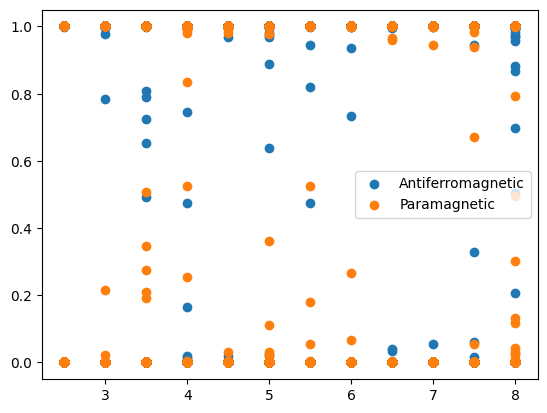

In [127]:
plt.scatter(Y_comb, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_comb, pred_class2, label='Paramagnetic')
plt.legend()

[[0.08239272 0.6047244  0.08239272 ... 0.08239272 0.6047244  0.08239272]
 [0.08239272 0.6047244  0.08239272 ... 0.08239272 0.6047244  0.08239272]
 [0.08239272 0.6047244  0.08239272 ... 0.08239272 0.6047244  0.08239272]
 ...
 [0.08239272 0.6047244  0.08239272 ... 0.08239272 0.6047244  0.08239272]
 [0.08239272 0.6047244  0.08239272 ... 0.08239272 0.6047244  0.08239272]
 [0.08239272 0.6047244  0.08239272 ... 0.08239272 0.6047244  0.08239272]]


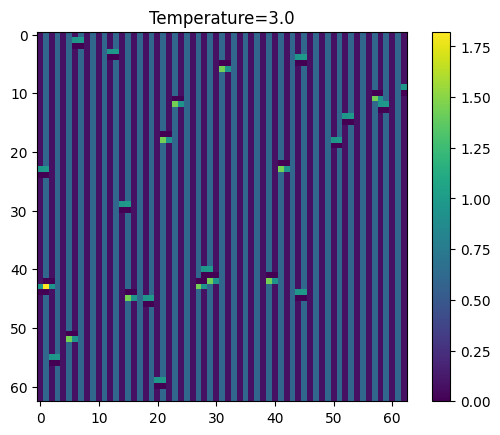

In [154]:
plot_feature_map(CNN2, X1[100], Y1[100], print_data = True)

###### Transfer learning on NNN R=+2 data

In [247]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = CNNstripes.conv1.weight.data
model2.conv1.bias.data = CNNstripes.conv1.bias.data
####
# model.fc1.weight.data = pretrained_model.fc1.weight.data
# model.fc1.bias.data = pretrained_model.fc1.bias.data

model2.fc2.weight.data = pretrained_model.fc2.weight.data
model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model2, num_epochs=20, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug123)


Loss: 0.6311445236206055 ,Train accuracy: 0.8046875
Loss: 0.18573588132858276 ,Train accuracy: 0.96875
Loss: 60.68537139892578 ,Train accuracy: 0.0703125
Loss: 0.4542888402938843 ,Train accuracy: 0.9453125
Loss: 2.6802117824554443 ,Train accuracy: 0.921875
Loss: 74.46214294433594 ,Train accuracy: 0.046875
Loss: 3.353804588317871 ,Train accuracy: 0.875
Loss: 3.794844150543213 ,Train accuracy: 0.8984375
Loss: 74.63880157470703 ,Train accuracy: 0.0859375
Loss: 2.2066478729248047 ,Train accuracy: 0.9453125
Loss: 2.0957694053649902 ,Train accuracy: 0.9609375
Loss: 82.76739501953125 ,Train accuracy: 0.0390625
Loss: 1.6702113151550293 ,Train accuracy: 0.9375
Loss: 3.063051700592041 ,Train accuracy: 0.921875
Loss: 75.49563598632812 ,Train accuracy: 0.1171875
Loss: 4.176292419433594 ,Train accuracy: 0.9375
Loss: 9.108317375183105 ,Train accuracy: 0.8515625
Loss: 78.2739028930664 ,Train accuracy: 0.09375
Loss: 6.229202747344971 ,Train accuracy: 0.8828125
Loss: 3.6259799003601074 ,Train accuracy:

In [248]:
test(model2, criterion, combined_dataloader_wo_aug123)

0 :: Loss: 6.864424705505371 ,Test accuracy: 0.8984375
1 :: Loss: 7.593120574951172 ,Test accuracy: 0.8828125
2 :: Loss: 8.374237060546875 ,Test accuracy: 0.90625
3 :: Loss: 7.682986259460449 ,Test accuracy: 0.8671875
4 :: Loss: 8.581506729125977 ,Test accuracy: 0.8984375
5 :: Loss: 12.813628196716309 ,Test accuracy: 0.84375
6 :: Loss: 11.642353057861328 ,Test accuracy: 0.8671875
7 :: Loss: 25.146757125854492 ,Test accuracy: 0.703125
8 :: Loss: 79.87289428710938 ,Test accuracy: 0.15625
9 :: Loss: 79.00057983398438 ,Test accuracy: 0.171875
10 :: Loss: 79.99528503417969 ,Test accuracy: 0.140625
11 :: Loss: 75.73442077636719 ,Test accuracy: 0.1953125
12 :: Loss: 79.87281036376953 ,Test accuracy: 0.1796875
13 :: Loss: 84.82415008544922 ,Test accuracy: 0.1328125
14 :: Loss: 83.70866394042969 ,Test accuracy: 0.1484375
15 :: Loss: 84.25352478027344 ,Test accuracy: 0.1171875
16 :: Loss: 79.3724594116211 ,Test accuracy: 0.15625
17 :: Loss: 80.77681732177734 ,Test accuracy: 0.140625
18 :: Loss: 

In [236]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model.conv1.weight.data = pretrained_model.conv1.weight.data
model.conv1.bias.data = pretrained_model.conv1.bias.data
####
# model.fc1.weight.data = pretrained_model.fc1.weight.data
# model.fc1.bias.data = pretrained_model.fc1.bias.data

model.fc2.weight.data = pretrained_model.fc2.weight.data
model.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
model.fc2.weight.requires_grad = True
model.fc2.bias.requires_grad = True

model.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=1e-3, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model, num_epochs=0, criterion=criterion, optimizer=optimizer, train_dataloader=combined_dataloader_wo_aug123)


In [249]:
pred_class1, pred_class2 = get_predictions(combined_dataloader_wo_aug123, model2)

In [250]:
a=np.array(pred_class1)
a.shape

(6000,)

In [251]:
Y_comb12 = np.append(Y1, Y2)
Y_comb123 = np.append(Y_comb12, Y3)
Y_comb123.shape

(6000,)

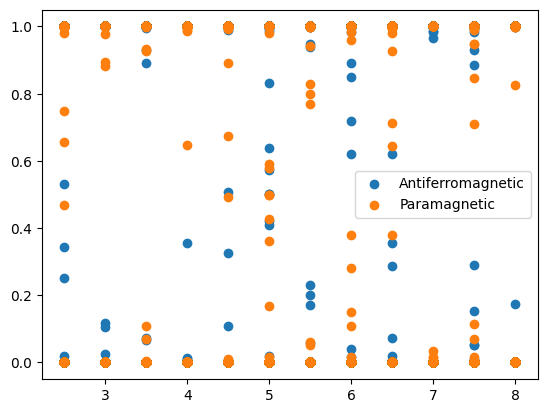

In [252]:
plt.scatter(Y_comb123, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_comb123, pred_class2, label='Paramagnetic')
plt.legend()

### Training CNN on horizontal and vertical stripes

In [212]:
import numpy as np

def generate_horizontal_stripes(size):
    stripes = np.zeros((size, size))
    for i in range(size):
        if i % 2 == 0:
            stripes[i] = 1
    return stripes

def generate_vertical_stripes(size):
    stripes = np.zeros((size, size))
    for i in range(size):
        if i % 2 == 0:
            stripes[:, i] = 1
    return stripes

def generate_dataset(num_samples, size):
    dataset = []
    labels = []
    for _ in range(num_samples // 2):
        horizontal_stripes = generate_horizontal_stripes(size)
        vertical_stripes = generate_vertical_stripes(size)
        dataset.append(horizontal_stripes)
        dataset.append(vertical_stripes)
        labels.append([0, 1])  # Label for horizontal stripes
        labels.append([1, 0])  # Label for vertical stripes
    return dataset, labels

# Generate the dataset
num_samples = 20000
size = 64
dataset, labels = generate_dataset(num_samples, size)

# Convert lists to numpy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Shuffle the dataset and labels
shuffle_indices = np.random.permutation(num_samples)
dataset = dataset[shuffle_indices]
labels = labels[shuffle_indices]

# Split the dataset into training and validation sets (80-20 split)
split_index = int(0.8 * num_samples)
train_dataset, val_dataset = dataset[:split_index], dataset[split_index:]
train_labels, val_labels = labels[:split_index], labels[split_index:]

# Print shapes of datasets and labels
print("Training dataset shape:", train_dataset.shape)
print("Training labels shape:", train_labels.shape)
print("Validation dataset shape:", val_dataset.shape)
print("Validation labels shape:", val_labels.shape)


Training dataset shape: (16000, 64, 64)
Training labels shape: (16000, 2)
Validation dataset shape: (4000, 64, 64)
Validation labels shape: (4000, 2)


In [214]:
import torch
from torch.utils.data import Dataset, DataLoader

class StripesDataset(Dataset):
    def __init__(self, dataset, labels, transform=None):
        self.dataset = dataset
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

# Define any transformations you want to apply to the data here
# For example, you can convert the NumPy array to a PyTorch tensor
transform = torch.tensor

# Create training and validation datasets
train_dataset = StripesDataset(train_dataset, train_labels, transform=transform)
val_dataset = StripesDataset(val_dataset, val_labels, transform=transform)

# Define batch size
batch_size = 32

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [217]:
CNNstripes = ConvNet(Nx, Ny)
CNNstripes.to(device)

# Setup optimizer
optimizer = optim.Adam(CNNstripes.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()

# Example usage of the training function with dataloader8
train(CNNstripes, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=train_dataloader)

Loss: 0.7014683485031128 ,Train accuracy: 0.46875
Loss: 0.00236326246522367 ,Train accuracy: 1.0
Loss: 0.002407826017588377 ,Train accuracy: 1.0
Loss: 3.644883236120222e-06 ,Train accuracy: 1.0
Loss: 4.0654881559021305e-06 ,Train accuracy: 1.0
Loss: 4.525090480456129e-05 ,Train accuracy: 1.0
Loss: 3.1272953492589295e-05 ,Train accuracy: 1.0
Loss: 1.907734940687078e-06 ,Train accuracy: 1.0
Loss: 0.0002373303286731243 ,Train accuracy: 1.0
Loss: 3.675221933008288e-06 ,Train accuracy: 1.0
Loss: 3.1851550374994986e-07 ,Train accuracy: 1.0
Loss: 7.123898285499308e-06 ,Train accuracy: 1.0
Loss: 0.0032088356092572212 ,Train accuracy: 1.0
Loss: 2.476069198564801e-07 ,Train accuracy: 1.0
Loss: 1.5857327525736764e-05 ,Train accuracy: 1.0
Loss: 3.094903831879492e-06 ,Train accuracy: 1.0
Loss: 2.2959338821237907e-05 ,Train accuracy: 1.0
Loss: 1.3799325415675412e-06 ,Train accuracy: 1.0
Loss: 2.768891960158726e-08 ,Train accuracy: 1.0
Loss: 0.00011195236584171653 ,Train accuracy: 1.0
Loss: 7.6094988

In [227]:
xstripe, ystripe = train_dataset[15999]

[[0.43600205 0.         0.43600205 ... 0.         0.         0.        ]
 [0.43600205 0.         0.43600205 ... 0.5069642  0.5069642  0.35303345]
 [0.43600205 0.         0.43600205 ... 0.         0.         0.        ]
 ...
 [0.5069642  0.35303345 0.         ... 0.43600205 0.         0.        ]
 [0.         0.         0.         ... 0.43600205 0.         0.43600205]
 [0.43600205 0.         0.43600205 ... 0.43600205 0.         0.43600205]]


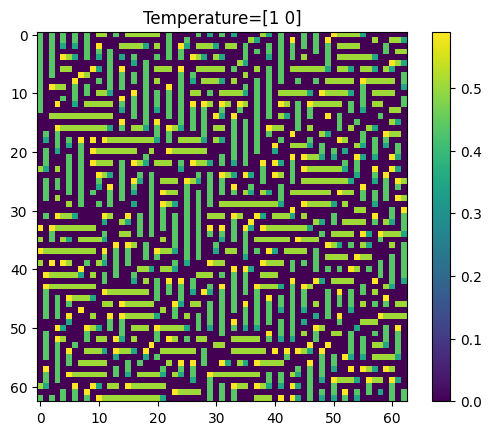

In [232]:
plot_feature_map(CNNstripes, X1[500], ystripe)

In [ ]:
plt.imshow()

In [ ]:
CNNstripes = ConvNet(64,64)


### Ideas

TO-DO List:
1. Print class attribution maps
2. Transfer learning in FCNN
3. Check for CNN